# Customer Segmentation & Lifetime Value Prediction

## Content

1. Libraries and Utilities
2. Load and Check Data
3. Understanding Data
4. Data Preprocessing
5. RFM Analysis
6. K-Means Clustering
7. Customer Lifetime Value

# Libraries and Utilities

In [293]:
!pip install plotly
!pip install Lifetimes

In [294]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
from lifetimes.plotting import plot_period_transactions
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

import warnings
warnings.filterwarnings('ignore')

# Load and Check Data

In [295]:
df = pd.read_csv('data.csv', header= 0, encoding= 'unicode_escape')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

# Understanding Data

In [296]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'#'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'#'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'#'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'#'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'#'))
    print(dataframe.isnull().sum())
    print(" QUANTILES ".center(70,'#'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

############################### SHAPE ################################
Rows: 541909
Columns: 8
############################### TYPES ################################
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
################################ HEAD ################################
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8

In [297]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
world_map = world_map.reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',locations = countries.index,locationmode = 'country names',
            z = countries,text = countries.index, colorbar = {'title':'Orders'},
            colorscale='Plasma',reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
              geo = dict(resolution=50,showocean=True, oceancolor="LightBlue",
                         showland=True, landcolor="Gray",showframe = True),
             template = 'plotly_white')

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## Descriptive Statistics

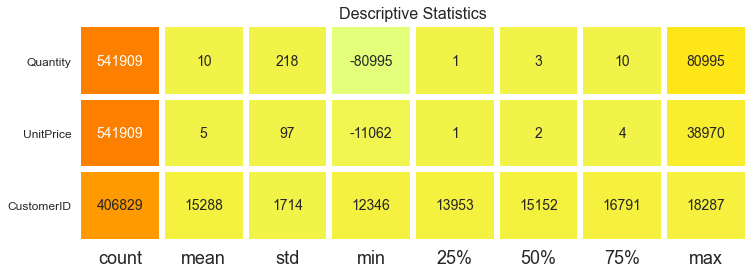

In [298]:
desc = df.describe().T
df1 = pd.DataFrame(index= [col for col in df.columns if df[col].dtype != 'O'], 
                   columns= ["count","mean","std","min","25%","50%","75%","max"],
                   data= desc )

f,ax = plt.subplots(figsize=(12,4))

sns.heatmap(df1, annot=True,cmap = "Wistia", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 14})

plt.xticks(size = 18)
plt.yticks(size = 12, rotation = 0)
plt.title("Descriptive Statistics", size = 16)
plt.show()

# Data Preprocessing

## Missing Values

In [299]:
df.dropna(inplace=True)
print('Missing Values: {}'.format(df.isnull().sum().sum()))

Missing Values: 0


## Cancelled Orders & Quantity

In [300]:
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

## Outliers

In [301]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")

## Total Price

In [302]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# RFM Analysis

## RFM Metrics

In [303]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [304]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda invoice_date: (today_date - invoice_date.max()).days,
                                    'InvoiceNo': lambda invoice: invoice.nunique(),
                                    'TotalPrice': lambda total_price: total_price.sum()})

rfm.columns = ['recency','frequency','monetary']
rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()
rfm.head()

CustomerID  recency  frequency  monetary
0     12346.0      326          1     326.0
1     12347.0        3          7       3.0
2     12348.0       76          4      76.0
3     12349.0       19          1      19.0
4     12350.0      311          1     311.0

## RFM Scores

In [305]:
rfm['recency_score'] = pd.qcut(rfm['recency'],5,labels=[5,4,3,2,1])

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"),5,labels=[1,2,3,4,5])

rfm['monetary_score'] = pd.qcut(rfm['monetary'],5,labels=[1,2,3,4,5])

rfm['RFM_SCORE'] = (rfm['recency_score'].astype(str)+ rfm['frequency_score'].astype(str))

## Segmentation

In [306]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head()

CustomerID  recency  frequency  monetary recency_score frequency_score  \
0     12346.0      326          1     326.0             1               1   
1     12347.0        3          7       3.0             5               5   
2     12348.0       76          4      76.0             2               4   
3     12349.0       19          1      19.0             4               1   
4     12350.0      311          1     311.0             1               1   

  monetary_score RFM_SCORE      segment  
0              5        11  hibernating  
1              1        55    champions  
2              4        24      at_Risk  
3              2        41    promising  
4              5        11  hibernating

## Segment Analysis

In [307]:
rfm[['recency','monetary','frequency','segment']].groupby('segment').agg({'mean','std','max','min'})

recency                            monetary        \
                        max min        mean        std      max   min   
segment                                                                 
about_to_sleep           72  34   53.312500  10.943474     72.0  34.0   
at_Risk                 374  73  153.785835  68.618828    374.0  73.0   
cant_loose              373  73  132.968254  65.250378    373.0  73.0   
champions                13   1    6.361769   3.683300     13.0   1.0   
hibernating             374  73  217.605042  92.013560    374.0  73.0   
loyal_customers          72  15   33.608059  15.577050     72.0  15.0   
need_attention           72  34   52.427807  11.552074     72.0  34.0   
new_customers            13   1    7.428571   3.902112     13.0   1.0   
potential_loyalists      33   1   17.398760   9.338808     33.0   1.0   
promising                33  15   23.421053   5.238115     33.0  15.0   

                                           frequency                            
                           mean        std       max min       mean        std  
segment                                                                         
about_to_sleep        53.312500  10.943474         2   1   1.161932   0.368913  
at_Risk              153.785835  68.618828         6   2   2.878583   0.954415  
cant_loose           132.968254  65.250378        34   6   8.380952   4.289630  
champions              6.361769   3.683300       210   3  12.417062  16.476484  
hibernating          217.605042  92.013560         2   1   1.101774   0.302492  
loyal_customers       33.608059  15.577050        63   3   6.479853   4.545669  
need_attention        52.427807  11.552074         3   2   2.326203   0.470081  
new_customers          7.428571   3.902112         1   1   1.000000   0.000000  
potential_loyalists   17.398760   9.338808         3   1   2.010331   0.651401  
promising             23.510638   5.192519         1   1   1.000000   0.000000

In [308]:
data = go.Bar(y = pd.DataFrame(rfm['segment'].value_counts()).index,
              x = pd.DataFrame(rfm['segment'].value_counts())['segment'].values,
              name = str(pd.DataFrame(rfm['segment'].value_counts())['segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1300])
iplot(fig)

In [309]:
fig = go.Figure()
for i in rfm['segment'].unique():
    fig.add_trace(go.Scatter(x=rfm[rfm['segment']==i]['recency'],
                           y=rfm[rfm['segment']==i]['frequency'],
                           mode='markers', name=str(i),showlegend = True,
                           marker = dict(size = 10,opacity = 0.6)))

fig.update_layout(title={'text': "Recency & Frequency by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                  legend=dict(x=0.8,y=1,bgcolor='rgba(255, 255, 255, 0)'),
                  xaxis = dict(title='Recency'),
                  yaxis=dict(title='Frequency'),
                  template='plotly_white')

fig.show()

# K-Means Clustering

In [310]:
kmeans_data = rfm.loc[:,['recency_score','frequency_score']]

inertia=[]
k = [1,2,3,4,5,6,7,8,9]
for i in k:
    kmean=KMeans(n_clusters=i)
    kmean.fit(kmeans_data)
    inertia.append(kmean.inertia_)
    
data = go.Scatter(x=k, y=inertia,mode='lines+markers',marker=dict(size=10))

layout = go.Layout(title={'text': "Elbow Method",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   width=650,height=470,
                   xaxis = dict(title='Number of Clusters'),
                   yaxis =dict(title='Sum of Squared Distance'),
                   template = 'plotly_white')

fig =go.Figure(data=data,layout=layout)
iplot(fig)

## Silhouette Score

In [311]:
kmeans = KMeans(n_clusters = 3,random_state = 42)
kmeans.fit(kmeans_data)
print('Silhouette Score: {}'.format(round(metrics.silhouette_score(kmeans_data, kmeans.labels_),3)))

Silhouette Score: 0.447


## Segment Analysis

In [312]:
rfm['k_means_segment'] = kmeans.labels_
rfm['k_means_segment'] = rfm['k_means_segment'].astype(str)
rfm[['recency','monetary','frequency','k_means_segment']].groupby('k_means_segment').agg({'mean','std','max','min'})

recency                            monetary                    \
                    max min        mean        std      max   min        mean   
k_means_segment                                                                 
0                   373   1   34.996445  40.345734    373.0   1.0   34.996445   
1                   374  73  204.631120  89.267019    374.0  73.0  204.631120   
2                    72   1   34.075862  20.364312     72.0   1.0   34.092321   

                           frequency                           
                       std       max min      mean        std  
k_means_segment                                                
0                40.345734       210   3  8.514810  11.060743  
1                89.267019         5   1  1.481556   0.748261  
2                20.365383         3   1  1.684483   0.708947

In [313]:
data = go.Bar(y = pd.DataFrame(rfm['k_means_segment'].value_counts()).index,
              x = pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values,
              name = str(pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by K-Means Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1900])
iplot(fig)

In [314]:
fig = make_subplots(rows=2,cols=3)

fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='0']['recency'],showlegend=False,
                     name = '0',marker_color='#1760E1'),row=1,col=1)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='1']['recency'],showlegend=False,
                     name = '1',marker_color='#1760E1'),row=1,col=2)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='2']['recency'],showlegend=False,
                     name = '2',marker_color='#1760E1'),row=1,col=3)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='0']['frequency'],showlegend=False,
                     name = '0',marker_color='#EB1919'),row=2,col=1)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='1']['frequency'],showlegend=False,
                     name = '1',marker_color='#EB1919'),row=2,col=2)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='2']['frequency'],showlegend=False,
                     name = '2',marker_color='#EB1919'),row=2,col=3)

fig.update_layout(title={'text': "Frequency & Recency by K-Means Segments",'y':0.9,'x':0.5,'xanchor': 'center',
        'yanchor': 'top'},template='plotly')

fig.update_yaxes(title_text="Recency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
iplot(fig)

# Customer Lifetime Value

In [315]:
cltv_df = df.groupby('CustomerID').agg({'InvoiceDate': [lambda invoice_date: (invoice_date.max() - invoice_date.min()).days,
                                                        lambda invoice_date: (today_date - invoice_date.min()).days], 
                                        'InvoiceNo': lambda invoice: invoice.nunique(),
                                        'TotalPrice': lambda total_price: total_price.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

recency    T  frequency  monetary
CustomerID                                   
12346.0           0  326          1    310.44
12347.0         365  368          7   4310.00
12348.0         282  359          4   1770.78
12349.0           0   19          1   1491.72
12350.0           0  311          1    331.46

## Average Order Value

In [316]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

## Recency & Tenure

In [317]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

## Frequency

In [318]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df.head()

recency          T  frequency    monetary
CustomerID                                             
12347.0     52.142857  52.571429          7  615.714286
12348.0     40.285714  51.285714          4  442.695000
12352.0     37.142857  42.428571          8  219.542500
12356.0     43.142857  46.571429          3  937.143333
12358.0     21.285714  21.571429          2  575.210000

## BG/NBD

In [319]:
bgf = BetaGeoFitter(penalizer_coef=0.001) #avoid overfitting

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

## Top 10 Expected Number of Transaction (1 Week)

In [320]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    3.265158
14911.0    3.126645
17841.0    1.940290
13089.0    1.537528
14606.0    1.463999
15311.0    1.433717
12971.0    1.357024
14646.0    1.222517
13408.0    0.986249
18102.0    0.968607
dtype: float64

## Top 10 Expected Number of Transaction (1 Month)

In [321]:
bgf.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    13.025670
14911.0    12.473095
17841.0     7.740345
13089.0     6.133456
14606.0     5.840269
15311.0     5.719467
12971.0     5.413481
14646.0     4.876360
13408.0     3.934373
18102.0     3.863856
dtype: float64

## Total Expected Number of Transaction (1 Month) 

In [322]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1777.145073163697

## Frequency of Repeat Transactions

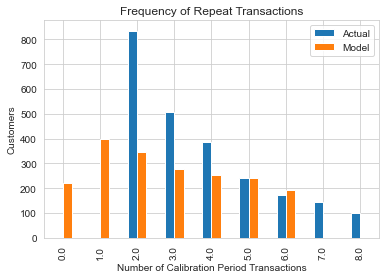

In [323]:
plot_period_transactions(bgf)
plt.show()

## Gamma-Gamma Submodel

In [324]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.80, q: 0.34, v: 3.73>

## Top 10 Expected Average Profit

In [325]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

CustomerID
12415.0    5772.177098
12590.0    5029.408953
12435.0    4288.934927
12409.0    3918.807445
14088.0    3917.128538
18102.0    3870.996680
12753.0    3678.575902
14646.0    3605.309143
15749.0    3216.047938
14096.0    3196.435322
dtype: float64

## CLTV

In [326]:
cltv = ggf.customer_lifetime_value(bgf,cltv_df['frequency'],
                                   cltv_df['recency'],cltv_df['T'],
                                   cltv_df['monetary'],time=6,
                                   freq="W",discount_rate=0.01)

## Top 10 CLTV (6 Months)

In [327]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

CustomerID            clv
1122     14646.0  108691.797610
2761     18102.0   92510.277355
843      14096.0   56135.699371
36       12415.0   53978.798679
1257     14911.0   53427.083011
2458     17450.0   53004.426445
874      14156.0   45708.064212
2487     17511.0   37047.559984
2075     16684.0   26217.822999
650      13694.0   25301.558007

## Segmentation

In [328]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv[["clv"]])
cltv["scaled_clv"] = scaler.transform(cltv[["clv"]])

cltv["segment"] = pd.qcut(cltv["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv.head()

CustomerID          clv  scaled_clv segment
0     12347.0  2200.757812    0.020248       A
1     12348.0  1050.352232    0.009664       B
2     12352.0  1007.740705    0.009272       B
3     12356.0  2109.557658    0.019409       A
4     12358.0  1870.554771    0.017210       A

## Segment Analysis

In [329]:
fig = make_subplots(rows=2,cols=2,subplot_titles=("A", "B",'C','D'))

fig.add_trace(go.Box(y =cltv[cltv['segment']=='A']['clv'],showlegend=False,
                     name = 'A',marker_color='#1760E1'),row=1,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='B']['clv'],showlegend=False,
                     name = 'B',marker_color='#1760E1'),row=1,col=2)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='C']['clv'],showlegend=False,
                     name = 'C',marker_color='#1760E1'),row=2,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='D']['clv'],showlegend=False,
                     name = 'D',marker_color='#1760E1'),row=2,col=2)

fig.update_layout(title={'text': "CLTV by SEGMENTS",'y':0.9,'x':0.5,'xanchor': 'center',
        'yanchor': 'top'},template='plotly')      
iplot(fig)

In [330]:
data = go.Bar(x = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['segment'],
              y = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],
              text = round(cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],3),
              textposition= 'auto',
              marker = dict(color = 'darkorange'))

layout = go.Layout(title={'text': "Average CLV by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis = dict(title='Segment'),
                   yaxis =dict(title='CLV'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_yaxes(range=[0,5100])
iplot(fig)